In [1]:
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np 
import scipy as sp
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import pandas as pd
import os
import re

import sys
sys.path.append('../')

from src.acquisition_func import ucb
from src.gaussian_process import Gaussain_Process
from src.bayesopt import Bayesopt
from src.kernels import iso_rbf

%load_ext autoreload
%autoreload 2

# Model functions

In [5]:
class Spline:

    def __init__(self, parameter_bound, y_bounds):
        
        self.bounds = parameter_bound
        self.y_bounds = y_bounds
        
        self.tck = None     
       
        self.X_obs = None
        self.Y_obs = None
        
        self.X_obs_std = None
        self.Y_obs_std = None
    
    def scale_observations(self):
    
        Nx = self.X_obs.shape[1]
        assert self.X_obs.shape[1] == self.bounds.shape[1]
        
        self.X_obs_std = np.zeros(self.X_obs.shape)
        for i in range(self.bounds.shape[1]):
            self.X_obs_std[:,i] = (self.X_obs[:,i] - self.bounds[0,i])/(self.bounds[1,i] - self.bounds[0,i])
        
        self.Y_obs_std = self.Y_obs

    def add_observation(self, x, y):
        """
            Adding new data to the model

        """
        x = x.reshape(x.shape[0],-1)
        y = y.reshape(y.shape[0],-1)
        
        if self.X_obs is None:
            self.X_obs = np.array(x).reshape(-1,x.shape[1])
            self.Y_obs = np.array(y).reshape(-1,y.shape[1])
            
        else:
            self.X_obs = np.append(self.X_obs,
                                   np.array(x).reshape(-1,x.shape[1]), axis=0)
            self.Y_obs = np.append(self.Y_obs,
                                   np.array(y).reshape(-1,y.shape[1]), axis=0)            
        self.scale_observations()

    def fit(self):
             
        self.txk = sp.interpolate.bisplrep(self.X_obs_std[:,0], self.X_obs_std[:,1], 
                                      self.Y_obs_std, 
                                      xb=0, xe=1,
                                      yb=self.y_bounds[0], ye=self.y_bounds[1]
                                     )

    def predict(self, x):
        
        x = x.reshape(x.shape[0],-1)
        assert x.shape[1] == self.X_obs.shape[1]
                
        # scale the test input
        x_std = np.copy(x)
        for i in range(self.bounds.shape[1]):
            x_std[:,i] = (x_std[:,i] - self.bounds[0,i])/(self.bounds[1,i] - self.bounds[0,i])
            
        val = sp.interpolate.bisplev(x_std[:,0], x_std[:,1],self.txk)
        val_grad = sp.interpolate.bisplev(x_std[:,0], x_std[:,1],self.txk, dx=1, dy=0)
        val_grad = val_grad / (self.bounds[1,0] - self.bounds[0,0])
        
        return val, val_grad

In [6]:
stress_dir = "/home/ashriva/work/beyond_finger_printing/ankit/Experiments/Data/raw/old_format/stress_data/"

df_stress = pd.DataFrame(columns=['Pressure','Final Film Stress_MPa'])
POWER = []
for path, subdirs, files in os.walk(stress_dir):
    for i, file in enumerate(files):
        arr = re.split('[^0-9a-zA-Z]+', file)
        power = int(re.findall(r'\d+', arr[-4])[0]) 
        press = int(re.findall(r'\d+', arr[-3])[0])
        if power == 750:
            colnames = ['Ar Pressure_mtorr','Final Film Stress_MPa']
        else:
            colnames = ['Argon Pressure_mTorr','Final Film Stress_MPa']
        if(i==0):
            temp_df = pd.read_csv(stress_dir+file, delimiter=',', 
                                  usecols=colnames)
            df_stress = pd.concat([df_stress,
                       temp_df.rename(columns={colnames[0]:'Pressure'})], 
                      ignore_index=True)
        else:
            temp_df = pd.read_csv(stress_dir+file, delimiter=',',
                                  usecols=colnames)
            df_stress = pd.concat([df_stress,
                       temp_df.rename(columns={colnames[0]:'Pressure'})], 
                      ignore_index=True)

        POWER.append(power)
        
df_stress['Power'] = POWER
df_stress['Pressure'] = df_stress['Pressure'].astype(int)

# df = df.drop(np.where(pd.isnull(df).iloc[:,-2])[0])

# stress_y_train = np.array(df_stress.iloc[:,-2]).astype(float) # Output : stress [N,1]
# stress_x_train = np.array(df_stress.iloc[:,[0,-1]]).astype(float) # Input : pressure, power [N,2]

In [7]:
import pathlib

data_dir = "/home/ashriva/work/beyond_finger_printing/ankit/Experiments/Data/raw/old_format/resistivity"
batches = os.listdir(data_dir)

resist_df = pd.DataFrame()
for batch in os.listdir(data_dir):
    df_temp = pd.read_csv(
                        os.path.join(data_dir, batch),
                        usecols=['Sputter Power (W)', 'Ar Pressure (mTorr)', 'Avg Sheet Resistance (ohm/sq)'],
                       )
    resist_df = pd.concat([resist_df, df_temp], ignore_index=True)
    
# resist_x_train = np.array(resist_df.iloc[:,[1,0]]).astype(float)
# resist_y_train = np.array(resist_df.iloc[:,[2]]).astype(float)

In [8]:
resist_df = resist_df.rename(columns={'Ar Pressure (mTorr)':'Pressure'})
resist_df = resist_df.rename(columns={'Sputter Power (W)':'Power'})

# data_df = pd.concat([resist_df, df_stress],  ignore_index=True)
# print(data_df.to_string())

resist_df_new = resist_df.sort_values(['Pressure', 'Power'], ascending=[True, True])
df_stress_new = df_stress.sort_values(['Pressure', 'Power'], ascending=[True, True])

df_stress_new['Avg Sheet Resistance (ohm/sq)'] = list(resist_df_new['Avg Sheet Resistance (ohm/sq)'])
df_stress_new.reset_index(inplace=True, drop=True)
df_stress_new = df_stress_new.drop(np.where(pd.isnull(df_stress_new).iloc[:,1])[0])

In [9]:
x_train = np.array(df_stress_new.iloc[:,[0,2]]).astype(float)
stress_y_train = np.array(df_stress_new.iloc[:,1]).astype(float)
resist_y_train = np.array(df_stress_new.iloc[:,3]).astype(float)

xx = np.linspace(2, 23, 100)
xx = np.append(xx,[2.,  3.,  5.,  8., 11., 14., 17., 20., 23.])
xx = np.unique(xx)

yy = np.linspace(50, 750, 21*2)
yy = np.append(yy, [100, 500, 750])
yy = np.unique(yy)

# Parameter grid setup
xx, yy = np.meshgrid(xx, yy)
x_test = np.append(xx.reshape(-1, 1),
                            yy.reshape(-1, 1),
                            axis=1)

# Fitting Stress vs (Pressure, Power)

## Gaussian Process

In [12]:
kernel = rbf([1, [.1, .1]])
para_bounds = np.array([[2, 50], [23, 750]])

GP_stress = Gaussain_Process(kernel, 
                             para_bounds)
GP_stress.noise = .1
## Temp code
import pickle
load_dir = "/home/ashriva/work/beyond_finger_printing/ankit/Experiments/Results/bayesopts/final_run"
run = 3
from run import stress_obj as obj_func
with open(load_dir + "/" + str(run) + '_gp_objects.pkl', 'rb') as file:
    data = pickle.load(file)
    GP_stress_temp = data['stress']
    x_train = GP_stress_temp.X_obs
    stress_y_train = GP_stress_temp.Y_obs
# ## ---------------------------

GP_stress.add_observation(x_train, 
                          stress_y_train)
print("negative_log_likelihood:", GP_stress.negative_log_likelihood())
stress_mu_gp = np.zeros([0,1])
stress_mu_gp_grad = np.zeros([0,1])
stress_sd = np.zeros([0,1])
    
for input_ in x_test:
    mu_, sd_, mu_grad_ = GP_stress.posterior(np.array(input_).reshape(1,-1), calc_grad=True)

    stress_mu_gp = np.append(stress_mu_gp, 
                             mu_.reshape(-1,1), 
                             axis=0)
    stress_mu_gp_grad = np.append(stress_mu_gp_grad, 
                               mu_grad_.reshape(-1,1), 
                               axis=0)
    stress_sd = np.append(stress_sd, 
                          sd_.reshape(-1,1), 
                          axis=0)

negative_log_likelihood: 14.407006197488784


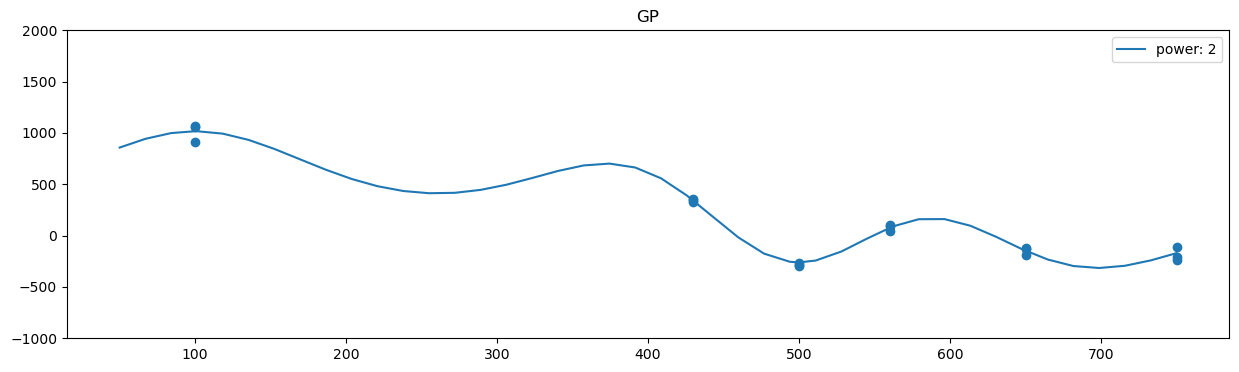

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,4))
for i, p in enumerate([2]):
    indx = x_train[:,0] == p
    ax.scatter(x_train[indx,1], stress_y_train[indx])
    indx = np.isclose(x_test[:,0], p, rtol=1e-05, atol=1e-08, equal_nan=False)
    ax.plot(x_test[indx,1], stress_mu_gp[indx], label="power: "+ str(p))
    
ax.set_title("GP")
ax.legend()
ax.set_ylim([-1000,2000])

plt.show()

## Spline

In [ ]:
para_bounds = np.array([[2,23],[50,750]])

SP_stress = Spline(para_bounds, [-2000, 2000])
SP_stress.add_observation(x_train, 
                          stress_y_train)
SP_stress.fit()

stress_mu_sp = []
stress_mu_sp_grad = []
for input_ in x_test:
    mu_, mu_grad_ = SP_stress.predict(np.array(input_).reshape(1,-1))
    stress_mu_sp.append(mu_)
    stress_mu_sp_grad.append(mu_grad_)

stress_mu_sp = np.array(stress_mu_sp)
stress_mu_sp_grad = np.array(stress_mu_sp_grad)

## Compare

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
for i, p in enumerate(np.unique(x_train[:,1])):
    indx = x_train[:,1] == p

    axs[0].scatter(x_train[indx,0], stress_y_train[indx])

    indx = np.isclose(x_test[:,1], p, rtol=1e-05, atol=1e-08, equal_nan=False)
    axs[0].plot(x_test[indx,0], stress_mu_sp[indx], label="power: "+ str(p))
    
axs[0].set_title("Spline")
axs[0].set_ylim([-1000,2000])
axs[0].legend()

for i, p in enumerate(np.unique(x_train[:,1])):
    indx = x_train[:,1] == p
    axs[1].scatter(x_train[indx,0], stress_y_train[indx])
    indx = np.isclose(x_test[:,1], p, rtol=1e-05, atol=1e-08, equal_nan=False)
    axs[1].plot(x_test[indx,0], stress_mu_gp[indx], label="power: "+ str(p))

axs[1].set_title("GP")
axs[1].legend()
axs[1].set_ylim([-1000,2000])

plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15,6))
axs = axs.reshape(-1)
for i, p in enumerate(np.unique(x_train[:,0])):
    indx = x_train[:,0] == p
    axs[i].scatter(x_train[indx,1], stress_y_train[indx])
    indx = np.isclose(x_test[:,0], p, rtol=1e-05, atol=1e-08, equal_nan=False)
    axs[i].plot(x_test[indx,1], stress_mu_gp[indx], label="power: "+ str(p))
    axs[i].set_title("GP")
    axs[i].legend()
    axs[i].set_ylim([-1000,2000])

plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
for i, p in enumerate(np.unique(x_train[:,1])):  
    indx = np.isclose(x_test[:,1], p, rtol=1e-05, atol=1e-08, equal_nan=False)
    axs[0].plot(x_test[indx,0], stress_mu_sp_grad[indx], label="power: "+ str(p))
    
axs[0].set_title("Spline")
axs[0].set_ylim([-1000,2000])
axs[0].legend()

for i, p in enumerate(np.unique(x_train[:,1])):
    indx = np.isclose(x_test[:,1], p, rtol=1e-05, atol=1e-08, equal_nan=False)
    axs[1].plot(x_test[indx,0], stress_mu_gp_grad[indx], label="power: "+ str(p))
axs[1].set_title("GP")
axs[1].legend()
axs[1].set_ylim([-1000,2000])

plt.show()

# Fitting Resistivity vs (Pressure, Power)

## Gaussian Process

In [18]:
kernel = rbf([1, [.3, .45]])
para_bounds = np.array([[2,23],[50,750]])

GP_resist = Gaussain_Process(kernel, para_bounds)

## Temp code
import pickle
load_dir = "/home/ashriva/work/beyond_finger_printing/ankit/Experiments/Results/bayesopts/final_run"
run = 3
from run import stress_obj as obj_func
with open(load_dir + "/" + str(run) + '_gp_objects.pkl', 'rb') as file:
    data = pickle.load(file)
    GP_resist_temp = data['resist']
    x_train = GP_resist_temp.X_obs
    resist_y_train = GP_resist_temp.Y_obs
# ## ---------------------------

GP_resist.add_observation(x_train, 
                          resist_y_train)
resist_mu_gp = np.zeros([0,1])
resist_sd = np.zeros([0,1])
    
for input_ in x_test:
    mu_, sd_ = GP_resist.posterior(np.array(input_).reshape(1,-1))

    resist_mu_gp = np.append(resist_mu_gp, 
                             mu_.reshape(-1,1), 
                             axis=0)
    resist_sd = np.append(resist_sd, 
                          sd_.reshape(-1,1),
                          axis=0)

## Spline

In [ ]:
para_bounds = np.array([[2,23],[50,750]])

SP_resist = Spline(para_bounds, [0, 100])
SP_resist.add_observation(x_train, 
                          resist_y_train)
SP_resist.fit()

resist_mu_sp = []
for input_ in x_test:
    mu_, _ = SP_resist.predict(np.array(input_).reshape(1,-1))
    resist_mu_sp.append(mu_)

resist_mu_sp = np.array(resist_mu_sp)

## Compare

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
for i, p in enumerate(np.unique(x_train[:,1])):
    indx = x_train[:,1] == p
    axs[0].scatter(x_train[indx,0], resist_y_train[indx])
    indx = np.isclose(x_test[:,1], p, rtol=1e-05, atol=1e-08, equal_nan=False)
    axs[0].plot(x_test[indx,0], resist_mu_sp[indx], label="power: "+ str(p))
    
axs[0].set_title("Spline")
axs[0].set_ylim([-1,50])
axs[0].legend()

for i, p in enumerate(np.unique(x_train[:,1])):
    indx = x_train[:,1] == p
    axs[1].scatter(x_train[indx,0], resist_y_train[indx])
    indx = np.isclose(x_test[:,1], p, rtol=1e-05, atol=1e-08, equal_nan=False)
    axs[1].plot(x_test[indx,0], resist_mu_gp[indx], label="power: "+ str(p))
axs[1].set_title("GP")
axs[1].legend()
axs[1].set_ylim([-1,50])

plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15,8))
axs = axs.reshape(-1)
for i, p in enumerate(np.unique(x_train[:,0])):
    indx = x_train[:,0] == p
    axs[i].scatter(x_train[indx,1], resist_y_train[indx])
    indx = np.isclose(x_test[:,0], p, rtol=1e-05, atol=1e-08, equal_nan=False)
    axs[i].plot(x_test[indx,1], resist_mu_gp[indx], label="power: "+ str(p))
    axs[i].set_title("GP")
    axs[i].legend()

fig.tight_layout()
plt.show()

In [ ]:
def softplus(x):                               # Softplus
    return np.log(1 + np.exp(x))

def sigmoid(x):

    return 1 / (1 + np.exp(-5*x))

a = []
for x in range(30):
    a.append(sigmoid(10-x))
    
plt.plot(a)

# Objective function design

In [14]:
def stress_obj_(stress, stress_grad, resistivity):
    
#     def Relu(x):
#         return x * (x > 0)
       
    def modified_sigmoid(x, d):

        x = d-x
        return 1 / (1 + np.exp(-5*x))

    def cutoff_func(x, d):
        
        def sigmoid(x):

            return 1 / (1 + np.exp(-x))

        f = sigmoid(d+x)+sigmoid(d-x)
        f = (f-1)

        return f
    
    def pos_grad_func(x):
        
        return (np.tanh(x)+1)/2
    
    def mingrad_func(x):
        
        return (-x/1900+1)
    
    min_grad_criteria = mingrad_func(stress_grad)
    pos_grad_criteria = pos_grad_func(stress_grad)
    stress_cutoff = cutoff_func(stress, 300)
    resistivity_cutoff = modified_sigmoid(resistivity ,3)

    switch = pos_grad_criteria*stress_cutoff*resistivity_cutoff
    obj = min_grad_criteria*switch
    
    return obj, min_grad_criteria, pos_grad_criteria, stress_cutoff, resistivity_cutoff

In [19]:
obj_array = np.zeros([0,1])
obj_array1 = np.zeros([0,1])
obj_array2 = np.zeros([0,1])
obj_array3 = np.zeros([0,1])
obj_array4 = np.zeros([0,1])

for stress_, stress_grad_, resit in zip(stress_mu_gp, stress_mu_gp_grad, resist_mu_gp):

    obj, obj1, obj2, obj3, obj4 = stress_obj_(stress_, stress_grad_, resit)
    obj_array = np.append(obj_array, obj.reshape(-1,1),axis=0)
    obj_array1 = np.append(obj_array1, obj1.reshape(-1,1),axis=0)
    obj_array2 = np.append(obj_array2, obj2.reshape(-1,1),axis=0)
    obj_array3 = np.append(obj_array3, obj3.reshape(-1,1),axis=0)
    obj_array4 = np.append(obj_array4, obj4.reshape(-1,1),axis=0)
    
obj_array_train = np.zeros([0,1])
obj_array1_train = np.zeros([0,1])
obj_array2_train = np.zeros([0,1])
obj_array3_train = np.zeros([0,1])
obj_array4_train = np.zeros([0,1])
    

stress_mu_gp_grad_train = np.zeros([0,1])
    
for input_ in x_train:
    mu_, sd_, mu_grad_ = GP_stress.posterior(np.array(input_).reshape(1,-1), calc_grad=True)
    stress_mu_gp_grad_train = np.append(stress_mu_gp_grad_train, 
                               mu_grad_.reshape(-1,1), 
                               axis=0)    
    
for stress_, stress_grad_, resit in zip(stress_y_train, stress_mu_gp_grad_train, resist_y_train):

    obj, obj1, obj2, obj3, obj4 = stress_obj_(stress_, stress_grad_, resit)
    obj_array_train = np.append(obj_array_train, obj.reshape(-1,1),axis=0)
    obj_array1_train = np.append(obj_array1_train, obj1.reshape(-1,1),axis=0)
    obj_array2_train = np.append(obj_array2_train, obj2.reshape(-1,1),axis=0)
    obj_array3_train = np.append(obj_array3_train, obj3.reshape(-1,1),axis=0)
    obj_array4_train = np.append(obj_array4_train, obj4.reshape(-1,1),axis=0)

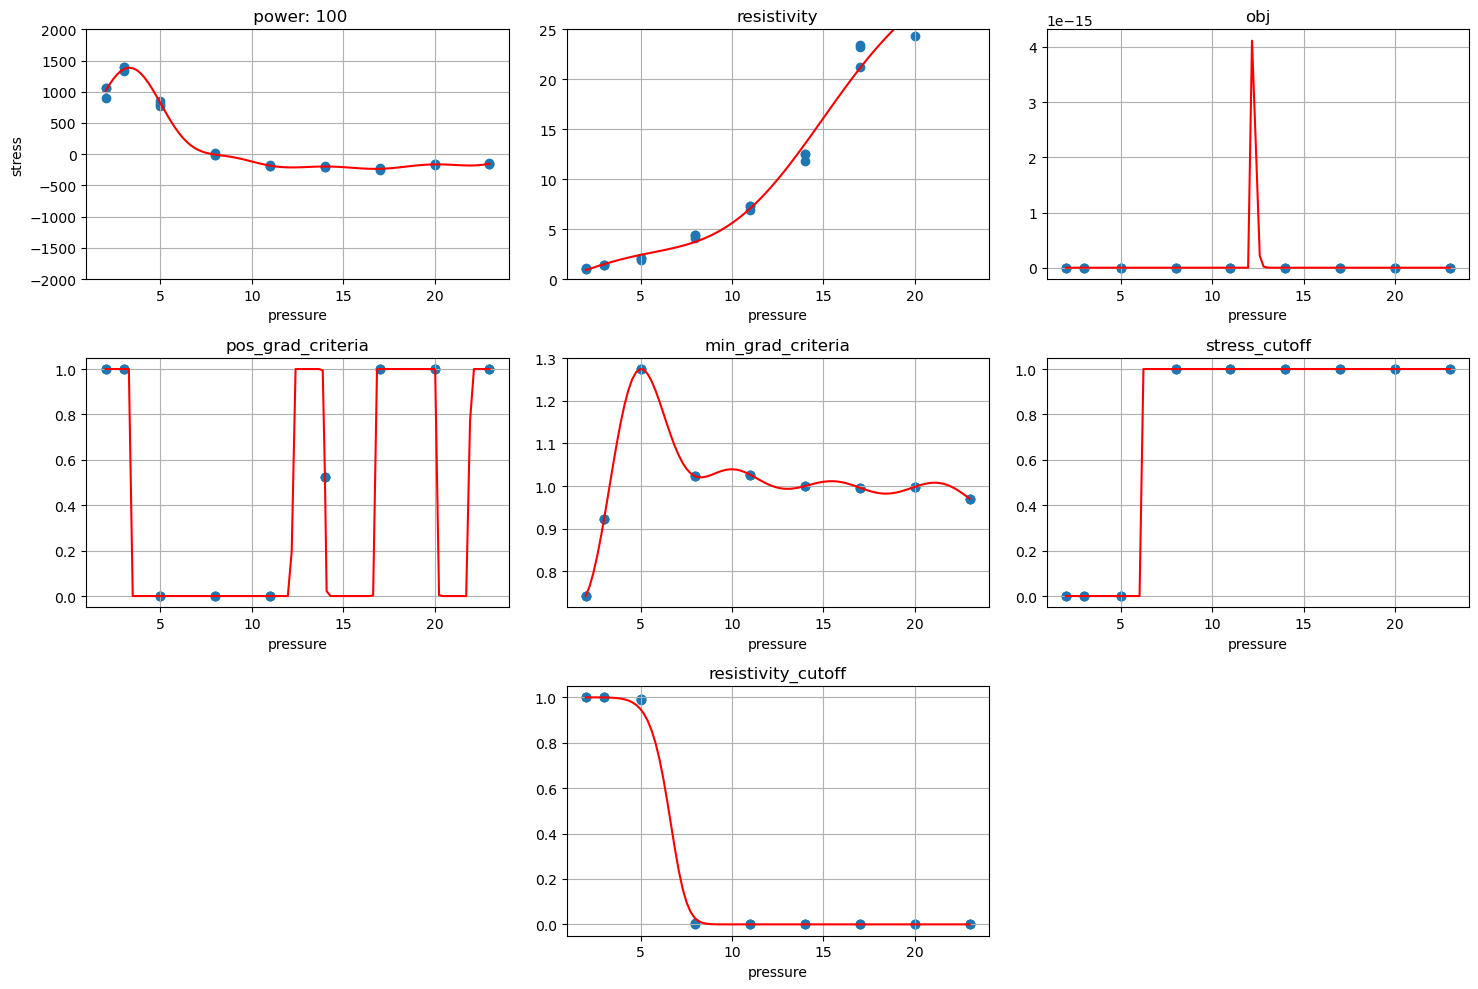

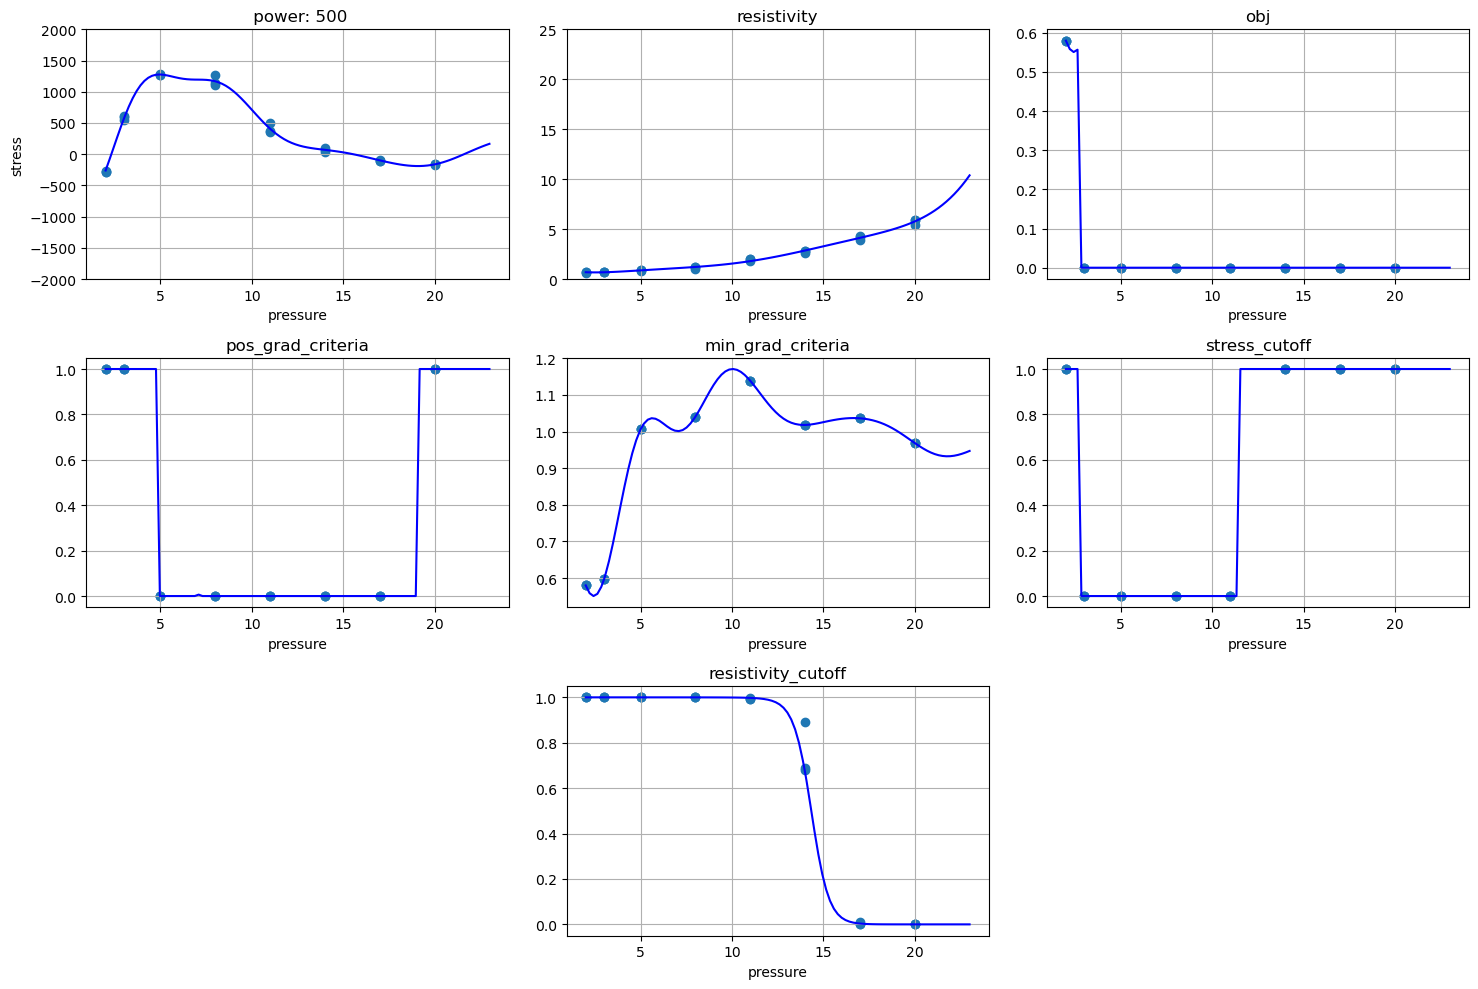

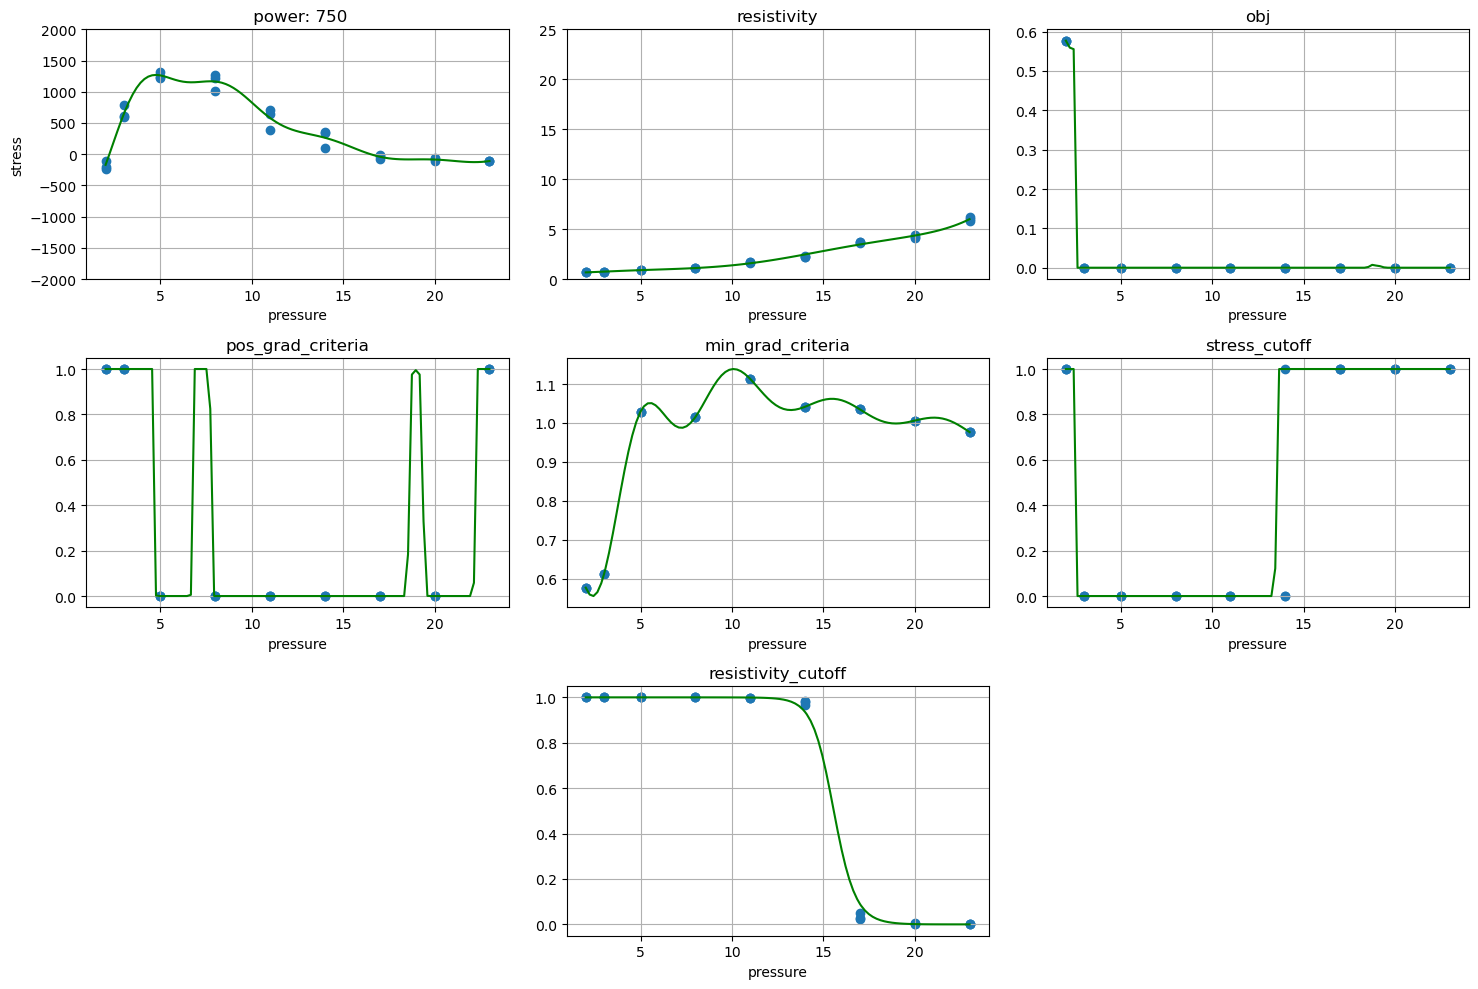

In [20]:
lcolor = ['r','b', 'g']
for i, p in enumerate([100,500,750]):
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=[15,10])
    axs = axs.reshape(-1)
    
    indx1 = x_train[:,1] == p
    
    indx = np.isclose(x_test[:,1], p, rtol=1e-05, atol=1e-08, equal_nan=False)
    axs[0].plot(x_test[indx,0], stress_mu_gp[indx,0], color=lcolor[i], label="power: "+ str(p))
    axs[0].scatter(x_train[indx1,0], stress_y_train[indx1])
#     axs[0].fill_between(x_test[indx,0], 
#                     mu[indx,0]+2*sd[indx,0], 
#                     mu[indx,0]-2*sd[indx,0], 
#                     alpha=0.5)
    axs[0].set_xlabel("pressure")
    axs[0].set_ylabel("stress")
    axs[0].set_title(" power: "+ str(p))
    axs[0].grid(True)
    axs[0].set_ylim([-2000,2000])
    
    axs[1].plot(x_test[indx,0], resist_mu_gp[indx,0], color=lcolor[i], label="power: "+ str(p))
    axs[1].scatter(x_train[indx1,0], resist_y_train[indx1])
    axs[1].set_xlabel("pressure")
    axs[1].set_title("resistivity")
    axs[1].set_ylim([0,25])
    axs[1].grid(True)
#     axs[1].remove()
       
    axs[4].plot(x_test[indx,0], obj_array1[indx,0], color=lcolor[i], label="power: "+ str(p))
    axs[4].scatter(x_train[indx1,0], obj_array1_train[indx1])
    axs[4].set_xlabel("pressure")
    axs[4].set_title("min_grad_criteria")
    
    axs[4].grid(True)

    axs[3].plot(x_test[indx,0], obj_array2[indx,0], color=lcolor[i], label="power: "+ str(p))
    axs[3].scatter(x_train[indx1,0], obj_array2_train[indx1])
    axs[3].set_xlabel("pressure")
    axs[3].set_title("pos_grad_criteria")
    
    axs[3].grid(True)
    
    axs[5].plot(x_test[indx,0], obj_array3[indx,0], color=lcolor[i])
    axs[5].scatter(x_train[indx1,0], obj_array3_train[indx1])
    axs[5].set_xlabel("pressure")
    axs[5].set_title("stress_cutoff")
    
    axs[5].grid(True)

    axs[7].plot(x_test[indx,0], obj_array4[indx,0], color=lcolor[i])
    axs[7].scatter(x_train[indx1,0], obj_array4_train[indx1])
    axs[7].set_xlabel("pressure")
    axs[7].set_title("resistivity_cutoff")
    
    axs[7].grid(True)    
    
    axs[2].plot(x_test[indx,0], obj_array[indx,0], color=lcolor[i], label="power: "+ str(p))
    axs[2].scatter(x_train[indx1,0], obj_array_train[indx1])
    axs[2].set_xlabel("pressure")
    axs[2].set_title("obj")
    
    axs[2].grid(True)
    
    fig.tight_layout()
    
    axs[6].remove()
    axs[8].remove()

plt.show()

In [ ]:
for i, p in enumerate(np.unique(x_train[:,0])):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[5,2])
    axs = axs.reshape(-1)
    
    indx = np.isclose(x_train[:,0], p, rtol=1e-05, atol=1e-08, equal_nan=False)

    axs[0].scatter(x_train[indx,1], stress_y_train[indx])

    indx = np.isclose(x_test[:,0], p, rtol=1e-05, atol=1e-08, equal_nan=False)
    axs[0].plot(x_test[indx,1], mu[indx,0], label="pressure: "+ str(p))
    axs[0].fill_between(x_test[indx,1], 
                    mu[indx,0]+2*sd[indx,0], 
                    mu[indx,0]-2*sd[indx,0], 
                    alpha=0.5)
    axs[0].set_xlabel("power")
    axs[0].set_ylabel("stress")
    axs[0].set_title(" power: "+ str(p))
    axs[0].grid(True)
    
    fig.tight_layout()

plt.show()

# For Presentation

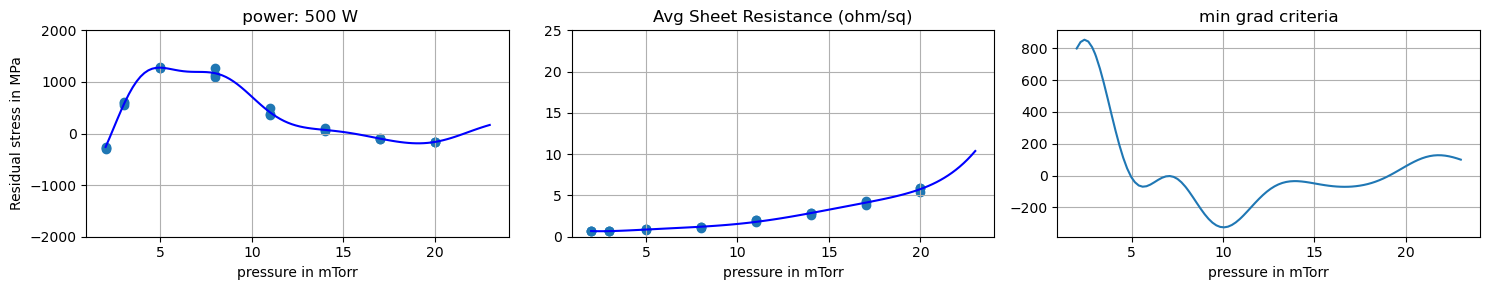

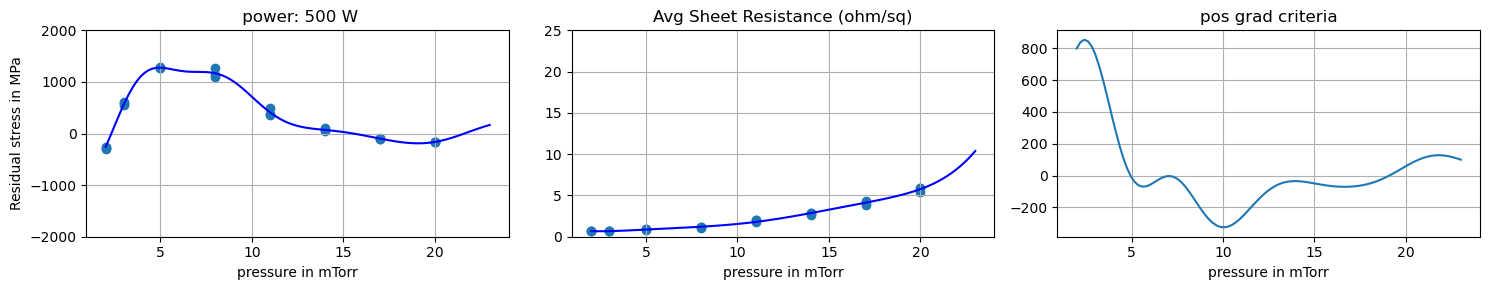

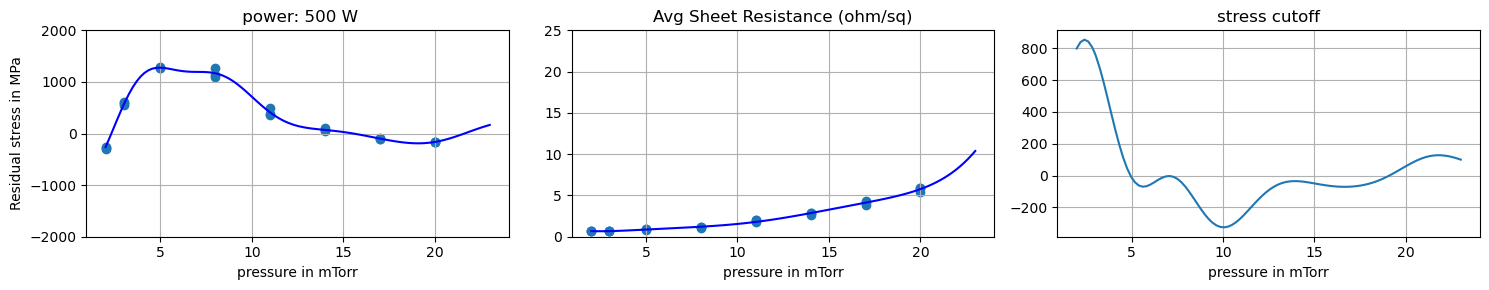

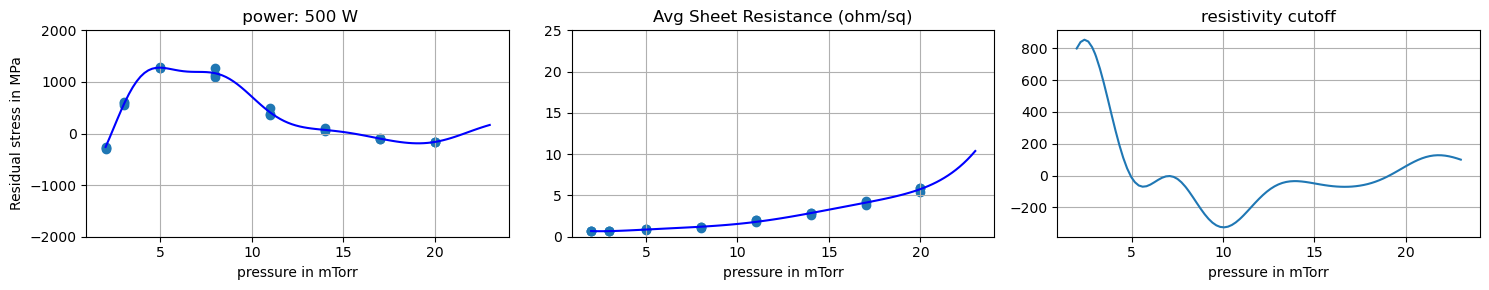

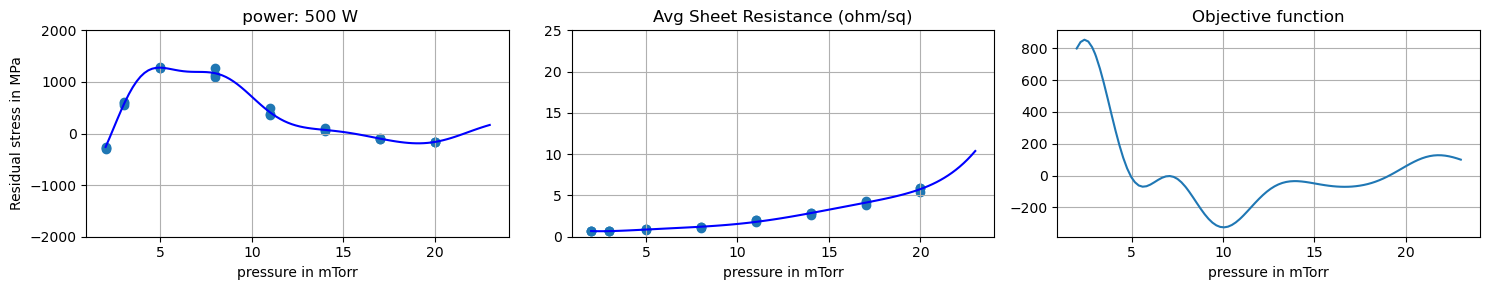

In [59]:
OBJ_ARRAY = [obj_array1, obj_array2, obj_array3, obj_array4, obj_array]
OBJ_ARRAY_train = [obj_array1_train, obj_array2_train, obj_array3_train, obj_array4_train, obj_array_train]
OBJ_label = ["min grad criteria", "pos grad criteria", "stress cutoff", "resistivity cutoff", "Objective function"]

lcolor = ['r','b', 'g']
for j in range(5):
    i = 1
    p = 500
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=[15,3])

    indx1 = x_train[:,1] == p
    indx = np.isclose(x_test[:,1], p, rtol=1e-05, atol=1e-08, equal_nan=False)
    
    axs[0].plot(x_test[indx,0], stress_mu_gp[indx,0], color=lcolor[i], label="power: "+ str(p))
    axs[0].scatter(x_train[indx1,0], stress_y_train[indx1])
    axs[0].set_xlabel("pressure in mTorr")
    axs[0].set_ylabel("Residual stress in MPa")
    axs[0].set_title(" power: "+ str(p) + " W")
    axs[0].grid(True)
    axs[0].set_ylim([-2000,2000])
    
    axs[1].plot(x_test[indx,0], resist_mu_gp[indx,0], color=lcolor[i], label="power: "+ str(p))
    axs[1].scatter(x_train[indx1,0], resist_y_train[indx1])
    axs[1].set_xlabel("pressure in mTorr")
    axs[1].set_title("Avg Sheet Resistance (ohm/sq)")
    axs[1].set_ylim([0,25])
    axs[1].grid(True)
#     axs[1].remove()

    axs[2].plot(x_test[indx,0], OBJ_ARRAY[j][indx], color=lcolor[i])
#     axs[2].plot(x_test[indx,0], stress_mu_gp_grad[indx, 0])
    axs[2].scatter(x_train[indx1,0], OBJ_ARRAY_train[j][indx1])
    axs[2].set_xlabel("pressure in mTorr")
    axs[2].set_title(OBJ_label[j])
    axs[2].set_ylim([-.02,1.2])
    axs[2].grid(True)

    fig.tight_layout()
#     plt.savefig("/home/ashriva/Desktop/obj"+str(j)+".png")
    plt.show()

# ROUGH

In [ ]:
class iso_rbf:
    
    def __init__(self, params):
        
        self.sigma = params[0]
        self.l = params[1] # lengthscale
        
    def grad(self, x1, x2):
    
        sigma = self.sigma
        l = self.l    
        
        xx = sigma**2*np.exp(-np.sum((x1-x2)**2, axis=1)/(2*l**2))
        val = xx*(sigma**2*(x1[0]-x2[0,0])/l**2)
        
        return val

    def __call__(self, x1, x2=None):
        if(x2 is None):
            x2 = 0
            
        sigma = self.sigma
        l = self.l        
        val = (sigma**2)*np.exp(-np.sum((x1-x2)**2, axis=1)/(2*l**2))
        
        return val
    
class rbf:
    
    def __init__(self, params):
        
        self.sigma = params[0]
        self.l = params[1] # lengthscale
        
    def grad(self, x1, x2):
    
        sigma = self.sigma
        l = np.array(self.l).reshape(1,-1)
        
        xx = sigma**2*np.exp(-np.sum((x1-x2)**2/(2*l**2), axis=1))
        val = xx*(sigma**2*(x1[0]-x2[0,0])/l[0,0]**2)
        
        return val

    def __call__(self, x1, x2=None):
        if(x2 is None):
            x2 = 0
            
        sigma = self.sigma
        l = np.array(self.l).reshape(1,-1)
        val = (sigma**2)*np.exp(-np.sum((x1-x2)**2/(2*l**2), axis=1))
        
        return val

In [ ]:
from sklearn.gaussian_process.kernels import RBF
import numpy as np
import matplotlib.pyplot as plt

xx, yy = np.meshgrid(
                    np.linspace(0, 1, 50), 
                    np.linspace(0, 1, 50)
                    )
x = np.append(xx.reshape(-1,1), 
              yy.reshape(-1,1), axis=1)
x0 = np.zeros([1,2])

for l in np.arange(.05,1.05,.05):
    kernel = rbf([1,[l,l]])
    val = []
    for a in x:
        a = a.reshape(1,-1)
    #     val.append(kernel.grad(x0[0,:],a))
        val.append(kernel(x0[0,:],a))
    val = np.array(val).reshape(xx.shape)
    # plt.pcolor(xx, yy, val)
    # plt.colorbar()
    # plt.show()
    indx = 0
    plt.plot(yy[:,indx], val[:,indx], label=str(l))
    iindx = np.isclose(val[:,indx],0)
    print(np.sum(iindx), yy[~iindx,indx][-1], l)
plt.legend()

# rbf = RBF([1,1])
# zz = rbf(X=x,Y=x0,eval_gradient=True).reshape(xx.shape)
# plt.pcolor(xx, yy, zz)
# plt.colorbar()
# plt.show()
# plt.plot(val[:,25])
# plt.plot(zz[:,25])

In [ ]:
import scipy as sp
f = sp.interpolate.interp2d(x_train[:,0], x_train[:,1], stress_train, kind='cubic')
z = []
z_grad = []
for i in range(2100):
    z.append(f(x_test[i,0], x_test[i,1]))
    z_grad.append(f(x_test[i,0], x_test[i,1], dx=1, dy=0))
mu = np.array(z)
mu_grad = np.array(z_grad)

In [ ]:
# import scipy as sp

# # f = sp.interpolate.interp2d(x_train[:,0], x_train[:,1], resist_train, kind='cubic')
# txk = sp.interpolate.bisplrep(stress_x_train[:,0], 
#                               stress_x_train[:,1], 
#                               stress_y_train, 
#                               xb=1, xe=30,
#                               yb = -2000, ye=2000
#                              )
# stress_mu_spline = []
# for i in range(2100): 
#     stress_mu_spline.append(sp.interpolate.bisplev(x_test[i,0], x_test[i,1],txk))
# stress_mu_spline = np.array(stress_mu_spline)

In [ ]:
# import scipy as sp

# # f = sp.interpolate.interp2d(x_train[:,0], x_train[:,1], resist_train, kind='cubic')
# txk = sp.interpolate.bisplrep(resist_x_train[:,0], resist_x_train[:,1], resist_y_train)
# resist_mu_spline = []
# for i in range(2100): 
#     print(sp.interpolate.bisplev(x_test[i,0], x_test[i,1], txk, dx=1, dy=0))
